<a href="https://colab.research.google.com/github/Harm1995/CTA-sensitivity/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  import gammapy
  import iminuit
  from iminuit import Minuit

except:

  !pip install gammapy
  !pip install iminuit

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math
from astropy.io import fits
from astropy import units as u
import gammapy
from gammapy.irf import Background3D
import pandas as pd 
import random
import scipy
from scipy.stats import norm
import seaborn as sns
import time

sns.set()


In [0]:
roi = 5
TeV = 10**-6
energy_start_bin = 3
offset = 1
pre_normalisation = 10**-20

# Downloading the data

In [0]:
pre_path = "/content/drive/My Drive/Colab Notebooks/master_project/"
ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"


### Here we get the diffusive emission maps:
ics_ring_maps = []
GCE_ring_maps = []
for i in range(1,5):
  ics = np.roll(fits.getdata(ring_path + 'ics_ring_'+str(i) +'.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  brems = np.roll(fits.getdata(ring_path + 'bremss_ring_'+ str(i) +'.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  pion = np.roll(fits.getdata(ring_path + 'pion_ring_1'+ str(i) +'.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  ics_ring_maps.append(ics)
  GCE_ring_maps.append(brems + pion)

GDE_maps = []
GDE_maps.append(ics_ring_maps)
GDE_maps.append(GCE_ring_maps)
GDE_maps = np.array(GDE_maps)

### We als need the fermi map and the signal map:
fermi_map = fits.getdata(pre_path + 'fig12_bubbles_template_3compSCA_40x40deg_inpaint.fits')
signal = np.roll(fits.getdata(pre_path + 'signal_ics_anisotropic_mapcube_56_NB.gz', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]

### And the irstrument respons function data:

irf_filename = pre_path + 'irf_file.fits'
aeff = gammapy.irf.EffectiveAreaTable2D.read(irf_filename, hdu="EFFECTIVE AREA")
edisp = gammapy.irf.EnergyDispersion2D.read(irf_filename, hdu="ENERGY DISPERSION")
psf = gammapy.irf.EnergyDependentMultiGaussPSF.read(irf_filename, hdu="POINT SPREAD FUNCTION")
bkg = Background3D.read(irf_filename, hdu='BACKGROUND')

def Eff_area(E_true):
   return (np.array(aeff.data.evaluate(energy=str(E_true) + " TeV", offset=str(offset) + "deg").to("cm2")))

# The energy list is some sort of tuple, via this way I make it a normal array of energies:
energy_list1 = np.array(fits.getdata(ring_path + 'ics_ring_1.fits', ext=1))
energies = []
for energy in energy_list1:
    E = float(str(energy)[1:-2])
    energies.append(E)
energies = np.array(energies)
energies = energies * TeV   


## Alternative data

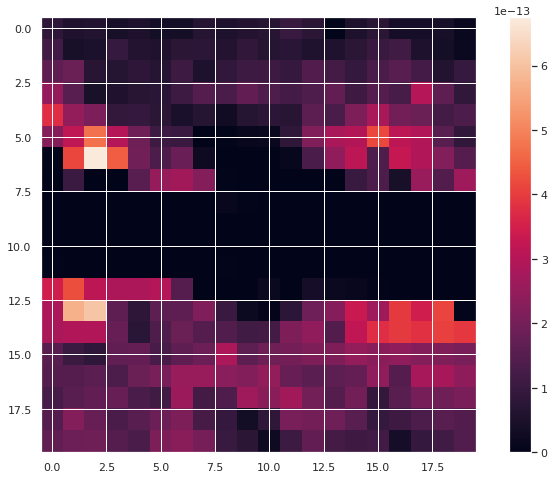

4.0981025e-08
4.098102630249158e-08


In [5]:
pre_path_alt = '/content/drive/My Drive/Colab Notebooks/master_project/Alternative_GDE/'

dust_pos =fits.getdata(pre_path_alt + 'DustPositive_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
dust_neg =fits.getdata(pre_path_alt + 'DustNegative_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]

dust_neg = np.array(dust_neg)
dust_pos = np.array(dust_pos)

H1_maps = []
H2_maps = []
for ring in range(1,5):
  map_H2 = fits.getdata(pre_path_alt + f'H2_pohl_ring_{ring}_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
  map_H1 = fits.getdata(pre_path_alt + f'HI_pohl_T150K_ring_{ring}_Normalized.fits')[(180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  H1_maps.append(map_H1)
  H2_maps.append(map_H2)

initial_norm_factor = (np.sum(H1_maps) + np.sum(H2_maps) + np.sum(dust_neg) + np.sum(dust_pos)) / np.sum(GCE_ring_maps) 
  
H1_maps_binned = []
H2_maps_binned = []

total_GCE = np.sum(GCE_ring_maps)
dust_pos_binned = []
dust_neg_binned = []

for e in range(len(energies)):
  sumo = 0
  for i in range(0,4):
    sumo += np.sum(GCE_ring_maps[i][e])
  frac = sumo / total_GCE
  dust_pos_binned.append(dust_pos * frac)
  dust_neg_binned.append(dust_neg * frac)


dust_pos_binned = np.array(dust_pos_binned) / initial_norm_factor
dust_neg_binned = np.array(dust_neg_binned) / initial_norm_factor

H1_maps_binned_tot = []
H2_maps_binned_tot = []
for ring in range(0,4):
  H1_maps_binned = []
  H2_maps_binned = []
  total = np.sum(GCE_ring_maps[ring])
  for e in range(len(energies)):
    sumi = np.sum(GCE_ring_maps[ring][e])
    frac = sumi / total
    H1_maps_binned.append(np.array(H1_maps[ring]*frac))
    H2_maps_binned.append(np.array(H2_maps[ring]*frac))
  H1_maps_binned_tot.append(H1_maps_binned)
  H2_maps_binned_tot.append(H2_maps_binned)

H1_maps_binned_tot = np.array(H1_maps_binned_tot) / initial_norm_factor
H2_maps_binned_tot = np.array(H2_maps_binned_tot) / initial_norm_factor

alternative_GDE = np.array([H1_maps_binned_tot,H2_maps_binned_tot,ics_ring_maps])
extras = np.array(dust_pos_binned + dust_neg_binned)

plt.figure(figsize=(12,8))
plt.imshow(dust_pos_binned[5])
plt.colorbar()
plt.show()


print (np.sum(GCE_ring_maps))
print (np.sum(H1_maps_binned_tot) + np.sum(H2_maps_binned_tot) + np.sum(dust_pos_binned) + np.sum(dust_neg_binned))

## Making the mask matrix

In [0]:
def mask_matrix_fu():

  catalog = fits.open(pre_path + 'gll_psch_v13.fit')

  ptsrc_long = []
  ptsrc_lat = []

  # Here is load all the point sources in our range of interest:
  for i in range(len(catalog[1].data)):
      if(catalog[1].data[i][9] > 4.0 and catalog[1].data[i][33] == ''):
          if(-roi + 180 <= catalog[1].data[i][3] <= roi + 180):
              if(-roi <= catalog[1].data[i][4] <= roi):
                  ptsrc_long.append(catalog[1].data[i][3])
                  ptsrc_lat.append(catalog[1].data[i][4])

  # Here I make a matrix that has a zero on all the positions that are +/- 0.25 degrees away from
  # a Fermi high energy source. Also the galactic ridge (+/- 0.3 degrees lattitude) are maskt.
  mask_matrix = []
  y_coor = 0
  x_min = 180 - roi
  x_max = 180 + roi
  y_min = - roi
  y_max = roi
  y_steps = 4 * roi
  x_steps = 4 * roi

  for y in np.linspace(y_max, y_min, y_steps):
      mask_matrix.append([])
      for x in np.linspace(x_min, x_max, x_steps):
          mark = 1
          for i in range(len(ptsrc_long)):
              ps_x = ptsrc_long[i]
              ps_y = ptsrc_lat[i]
              if abs(ps_x - x) < 0.25:
                  if abs(ps_y - y) < 0.25:
                      mark = 0
                      break
  #            if ((ps_x - x)**2 + (ps_y - y)**2)**0.5  < 0.25:
  #                mark = 0
          if abs(y) < 0.3:
              mark = 0
          mask_matrix[y_coor].append(mark)
      y_coor += 1

  mask_matrix = np.array(mask_matrix)
  return mask_matrix

def random_counts_with_signal(signal_strength,sigma, all_backgrounds, signal_conv):
  count_matrix = np.zeros(signal_conv.shape)
  for k,i,j in np.ndindex(signal_conv.shape):
    for mapn in all_backgrounds:
      expected = mapn[k][i][j]
      if expected > 0:
        count_matrix[k][i][j] +=  np.random.normal(expected, sigma*expected)
    expected = signal_conv[k][i][j] * signal_strength
    count_matrix[k][i][j] +=  np.random.normal(expected, sigma*expected)

  return count_matrix


# Making the classes

## Creating the count maps

In [0]:
class counts_maps:

  def __init__(self, GDE_maps, signal_map, extra_maps):

    "The Fermi_map"
    fermi_map = fits.getdata(pre_path + 'fig12_bubbles_template_3compSCA_40x40deg_inpaint.fits')
    norm = np.sum(fermi_map) * (np.pi/180.0)**2.0 * (0.5**2.0)
    fermi_map = fermi_map[(40 - 2*roi):(40 + 2 * roi),
                          (40 - 2*roi):(40 + 2 * roi)] / norm
                        
    self.fermi_map = fermi_map
    self.GDE_maps = GDE_maps
    self.signal_map = signal_map
    self.mask_matrix = mask_matrix_fu()
    self.extra_maps = extra_maps
                        
  
  def __fermi_function(self, E):
    phi0 = 1 * 10**-8
    sigma = 1.9
    E_co = 20

    fluxq = phi0 * np.exp(-E/E_co) * E ** -sigma * 5 **2 * (np.pi / 180) **2
    return fluxq

  def fermi_bubbles(self, i, j, E):
    fermi_bubble = self.__fermi_function(E)
    place_factor = self.fermi_map[i][j]

    return fermi_bubble * place_factor

  def signal_conv(self):
    signal_conv = np.zeros(shape = signal.shape)
    fermi_bubble_conv = np.zeros(shape = signal.shape)
    for k,i,j in np.ndindex(signal_conv.shape):
      if k < (len(energies)-1):
        E1 = energies[k]
        E2 = energies[k + 1]
        dE = E2 - E1
        fermi_bubble_conv[k][i][j] = self.fermi_bubbles(i, j, E1) * Eff_area(E1) * dE
        signal_conv[k][i][j] = self.signal_map[k][i][j] / TeV * Eff_area(E1) * dE * pre_normalisation

    return signal_conv * self.mask_matrix

  def fermi_bubbles_conv(self):
    fermi_bubble_conv = np.zeros(shape = signal.shape)
    for k,i,j in np.ndindex(fermi_bubble_conv.shape):
      if k < (len(energies)-1):
        E1 = energies[k]
        E2 = energies[k + 1]
        dE = E2 - E1
        fermi_bubble_conv[k][i][j] = self.fermi_bubbles(i, j, E1) * Eff_area(E1) * dE

    return fermi_bubble_conv * self.mask_matrix

  def convolving_GDE(self):

    GDE_conv= np.zeros(shape = self.GDE_maps.shape)

    for types,ring,k,i,j in np.ndindex(GDE_conv.shape):
      if k < (len(energies)-1):
        E1 = energies[k]
        E2 = energies[k + 1]
        dE = E2 - E1
        GDE_conv[types][ring][k][i][j] = self.GDE_maps[types][ring][k][i][j] / TeV * Eff_area(E1) * dE

    return GDE_conv * self.mask_matrix
  
  def extra_maps_conv(self):
    if len(self.extra_maps) == 0:
      return ("There are no extra maps")
    else:
      extras_conv= np.zeros(shape = self.extra_maps.shape)

      for types,k,i,j in np.ndindex(self.extra_maps.shape):
        if k < (len(energies)-1):
          E1 = energies[k]
          E2 = energies[k + 1]
          dE = E2 - E1
          extras_conv[types][k][i][j] =self.extra_maps[types][k][i][j] / TeV * Eff_area(E1) * dE
      return extras_conv



  def get_all_backgrounds(self):
    all_backgrounds = []
    GDE_maps = self.convolving_GDE()
    for types in GDE_maps:
      for rings in types:
        all_backgrounds.append(rings)
    fermi_map = self.fermi_bubbles_conv()
    all_backgrounds.append(fermi_map)
    if len(self.extra_maps) != 0:
      extras = self.extra_maps_conv()
      for maps in extras:
        all_backgrounds.append(maps)
    return np.array(all_backgrounds)


  
  def plot_maps(self):

    a = self.convolving_GDE()
    i,j,*e = a.shape
    energy_bin = 18
    Energie_plot = energies[energy_bin]
    fig, ax = plt.subplots(i+1,j, figsize = (15,11))
    for x in range(i):
      for y  in range(j):
        m1 = ax[x][y].imshow(a[x][y][20])
        plt.colorbar(m1, ax = ax[x][y])
    
    fermi_map = self.fermi_bubbles_conv()
    signal_map = self.signal_conv()
    m3 = ax[i][1].imshow(fermi_map[energy_bin], extent=[-5, 5, -5, 5])
    m4 = ax[i][2].imshow(signal_map[energy_bin], extent=[-5, 5, -5, 5])
    plt.colorbar(m3, ax = ax[2][1])
    plt.colorbar(m4, ax = ax[2][2])
    fig.delaxes(ax[i,0])
    fig.delaxes(ax[i,3])
    
    fig.suptitle("expected counts per bin  for E =" +
             str(round(Energie_plot, 2)) + ' TeV', fontsize=16)
    plt.show()


## analysis


In [0]:

class analysis:

  def __init__(self, signal_strength, model_backgrounds, signal_conv,sigma,simulated_backgrounds, long):
    self.signal_strength = signal_strength
    self.simulated_backgrounds = simulated_backgrounds
    self.counts_m = random_counts_with_signal(signal_strength,sigma, simulated_backgrounds, signal_conv)
    self.all_backgrounds = model_backgrounds
    self.signal_conv = signal_conv
    self.sigma = sigma
    self.long = long

#  def random_counts_with_signal(self):
#    count_matrix = np.zeros(self.signal_conv.shape)
#    for k,i,j in np.ndindex(self.signal_conv.shape):
#      for mapn in self.all_backgrounds:
#        expected = mapn[k][i][j]
#        if expected > 0:
#          count_matrix[k][i][j] +=  np.random.normal(expected, self.sigma*expected)
#      expected = self.signal_conv[k][i][j] * self.signal_strength
#      count_matrix[k][i][j] +=  np.random.normal(expected, self.sigma*expected)
#
#    return count_matrix  

  
  def L0_model_long(self, params, i,j,k):
    """
    The model for CTA without a signal component
    """

    tot_back = 0
    for a in range(len(self.all_backgrounds)):
      tot_back += params[a] * self.all_backgrounds[a][k][i][j]
    return tot_back

  def L1_model_long(self, params, i,j,k):
    """
    The model for CTA with a signal component
    """

    tot_back = 0
    for a in range(len(self.all_backgrounds)):
      tot_back += params[a] * self.all_backgrounds[a][k][i][j]  
    
    tot_back += params[-1] * self.signal_conv[k][i][j]
    
    return tot_back

  def L0_model_short(self, params, i,j,k):
    """
    The model for CTA without a signal component
    """
    tot_back = 0

    for a in range(len(self.all_backgrounds)):
      if a < 4:
        tot_back += params[0] * self.all_backgrounds[a][k][i][j]
      elif a < 8:
        tot_back += params[1] * self.all_backgrounds[a][k][i][j]
      else:
        tot_back += params[2] * self.all_backgrounds[a][k][i][j]

    return tot_back


  def L1_model_short(self, params, i,j,k):
      """
      The model for CTA with a signal component
      """
      tot_back = 0

      for a in range(len(self.all_backgrounds)):
        if a < 4:
          tot_back += params[0] * self.all_backgrounds[a][k][i][j]
        elif a < 8:
          tot_back += params[1] * self.all_backgrounds[a][k][i][j]
        else:
          tot_back += params[2] * self.all_backgrounds[a][k][i][j]

      tot_back += params[3] * self.signal_conv[k][i][j]
      return tot_back


  def lik0(self,params):
    """
    Function that computes the likelihood for a given set of parameters without a signal
    """
    if long == True:
      p_sum = 0
      for k,i,j in np.ndindex(self.signal_conv.shape):
        counts = self.counts_m[k][i][j]
        counts_model = self.L0_model_long(params, i,j,k)
        if counts_model > 0:  
          p = counts * np.log(counts_model) - counts_model
          p_sum += p
      return -p_sum
    else:
      p_sum = 0
      for k,i,j in np.ndindex(self.signal_conv.shape):
        counts = self.counts_m[k][i][j]
        counts_model = self.L0_model_short(params, i,j,k)
        if counts_model > 0:  
          p = counts * np.log(counts_model) - counts_model
          p_sum += p
      return -p_sum



  def lik1(self,params):
    """
    Function that computes the likelihood for a given set of parameters of the model with a signal 
    """
    if long == True:
      p_sum = 0
      for k,i,j in np.ndindex(self.signal_conv.shape):
        counts = self.counts_m[k][i][j]
        counts_model = self.L1_model_long(params, i,j,k)
        if counts_model > 0:  
          p = counts * np.log(counts_model) - counts_model
          p_sum += p
      return -p_sum
    else:
      p_sum = 0
      for k,i,j in np.ndindex(self.signal_conv.shape):
        counts = self.counts_m[k][i][j]
        counts_model = self.L1_model_short(params, i,j,k)
        if counts_model > 0:  
          p = counts * np.log(counts_model) - counts_model
          p_sum += p
      return -p_sum




  def Test_stat(self):
    if long == True:
      init_gues0 = []
      init_gues1 = []
      range0 = (0.7, 1.3)
      range1 = (0.7, 1.3)
      limit_list1 = []
      limit_list2 = []
      for __ in range(len(self.all_backgrounds)):
        init_gues0.append(1)
        init_gues1.append(1)
        limit_list1.append(range0)
        limit_list2.append(range1)
      limit_list2.append((0, None))
      init_gues1.append(self.signal_strength)
      m_0 = Minuit.from_array_func(self.lik0, init_gues0, error = 0.1, limit= limit_list1, errordef=0.5)
      m_1 = Minuit.from_array_func(self.lik1, init_gues1, error = 0.1, limit= limit_list2, errordef=0.5)
      c = m_0.migrad() 
      d = m_1.migrad()
      a = -m_0.fval 
      b = -m_1.fval
      T = -2*(a-b)
      return T, c,d
    else:
      init_gues0 = [1,1,1]
      init_gues1 = [1,1,1,self.signal_strength]
      range0 = (0.5, 2.5)
      range1 = (0.7, 1.3)
      m_0 = Minuit.from_array_func(self.lik0, init_gues0, error = 0.25, limit= [range0,range0,range0], errordef=0.5,)
      m_1 = Minuit.from_array_func(self.lik1, init_gues1, error = 0.25, limit= [range1,range1,range1,(0, None)], errordef=0.5)
      m_0.migrad()
      m_1.migrad()
      a = -m_0.fval 
      b = -m_1.fval
      T = -2*(a-b)
      return T, m_1.get_param_states()





# Analysing the data

In [0]:
### Making the count maps
GDE_maps = np.array([ics_ring_maps, GCE_ring_maps])
alternative_GDE = np.array([ics_ring_maps, H1_maps_binned_tot,H2_maps_binned_tot])
extras = np.array([dust_pos_binned, dust_neg_binned])
MAPS_alternative = counts_maps(alternative_GDE, signal,extras)
MAPS_orig = counts_maps(GDE_maps, signal,[])


In [10]:
simulated_backgrounds = MAPS_orig.get_all_backgrounds()
model_backgrounds = MAPS_alternative.get_all_backgrounds()
signal_c = MAPS_orig.signal_conv()
print (simulated_backgrounds.shape)
print (model_backgrounds.shape)


(9, 47, 20, 20)
(15, 47, 20, 20)


In [0]:

print (np.sum(simulated_backgrounds))
print (np.sum(model_backgrounds))
print ("---------------")

print (np.sum(model_backgrounds[4:12])+np.sum(model_backgrounds[14:16]))
print (np.sum(simulated_backgrounds[4:8]))
print ("---------------")
print (np.sum(GDE_maps[1]))
print (np.sum(alternative_GDE[1:3])+np.sum(extras))


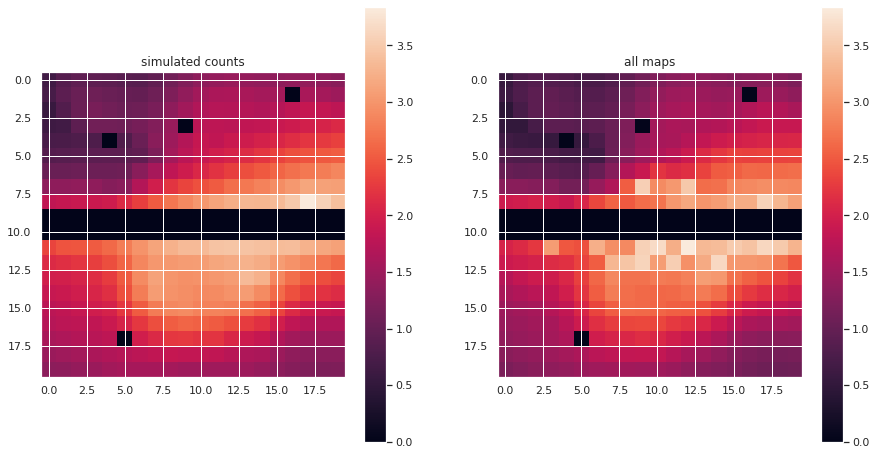

27754.198560585108
31091.977857518676


In [0]:
signal_strength = 0.05
sigma = 0
long = True
M1 = analysis(signal_strength, model_backgrounds, signal_c, sigma, simulated_backgrounds, long)
M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)

a = M1.counts_m
b = M2.counts_m

tot = np.zeros(shape = model_backgrounds[1].shape)
for maps in model_backgrounds:
  tot += maps



index = 20
fig, ax = plt.subplots(1,2, figsize = (15,8))
m1 = ax[0].imshow(a[index])
m2 = ax[1].imshow(tot[index])
ax[0].set_title('simulated counts')
ax[1].set_title('all maps')
plt.colorbar(m1, ax = ax[0])
plt.colorbar(m2, ax = ax[1])
m1.set_clim(0, np.max(a[index]))
m2.set_clim(0, np.max(a[index]))
plt.show()

print (np.sum(tot))
print (np.sum(a))


In [0]:
signal_strength = 0.05
sigma = 0
long = True
M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)
T, c,d = M2.Test_stat()

## Sigma = 0, ss = 0.05, Original GDE model


In [0]:
signal_strength = 0.05
sigma = 0
long = True
M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)
T, c,d = M2.Test_stat()



In [0]:
c

------------------------------------------------------------------
| FCN = -8890                   |     Ncalls=885 (885 total)     |
| EDM = 7.7E-05 (Goal: 5E-06)   |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |    1.3    |    0.7    |            |            |   0.6   |   1.5   |       |
| 1 | x1   |   0.92    |   0.17    |            |            |   0.6   |   1.5   |       |
| 2 | x2   |    1.5    |    0.9    |            |            |   0.6   |   1.5   |       |
| 3 | x3   |    1.5    |    0.9    |            |            |   0.6   |   1.5   |       |
| 4 | x4   |   1.03    |   0.22    |            |            |   0.6   |   1.5   |       |
| 5 | x5   |   0.94    |   0.06    |            |            |   0.6   |   1.5   |       |
| 6 | x6   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 7 | x7   |   1.50    |   0.19    |            |            |   0.6   |   1.5   |       |
| 8 | x8   |   1.011   |   0.024   |            |            |   0.6   |   1.5   |       |
------------------------------------------------------------------------------------------

In [0]:
d


------------------------------------------------------------------
| FCN = -8894                   |     Ncalls=156 (156 total)     |
| EDM = 5.64E-12 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   1.00    |   0.28    |            |            |   0.6   |   1.5   |       |
| 1 | x1   |   1.00    |   0.17    |            |            |   0.6   |   1.5   |       |
| 2 | x2   |    1.0    |    0.5    |            |            |   0.6   |   1.5   |       |
| 3 | x3   |    1.0    |    0.5    |            |            |   0.6   |   1.5   |       |
| 4 | x4   |   1.00    |   0.27    |            |            |   0.6   |   1.5   |       |
| 5 | x5   |   1.00    |   0.08    |            |            |   0.6   |   1.5   |       |
| 6 | x6   |    1.0    |    0.6    |            |            |   0.6   |   1.5   |       |
| 7 | x7   |    1.0    |    0.6    |            |            |   0.6   |   1.5   |       |
| 8 | x8   |   1.000   |   0.024   |            |            |   0.6   |   1.5   |       |
| 9 | x9   |   0.050   |   0.018   |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [0]:
print (T)

7.325685234874982


## Sigma = 0, ss = 0.05 alternative GDE

In [0]:
sigma = 0
signal_strength = 0.05
long = True
M1 = analysis(signal_strength, model_backgrounds, signal_c, sigma, simulated_backgrounds, long)

T, c,d = M1.Test_stat()

In [0]:
c

------------------------------------------------------------------
| FCN = -8689                   |    Ncalls=1053 (1053 total)    |
| EDM = 1.94E-05 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   1.500   |   0.010   |            |            |   0.6   |   1.5   |       |
| 1 | x1   |   1.500   |   0.006   |            |            |   0.6   |   1.5   |       |
| 2 | x2   |   1.50    |   0.08    |            |            |   0.6   |   1.5   |       |
| 3 | x3   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 4 | x4   |   0.60    |   0.05    |            |            |   0.6   |   1.5   |       |
| 5 | x5   |   1.50    |   0.09    |            |            |   0.6   |   1.5   |       |
| 6 | x6   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 7 | x7   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 8 | x8   |   0.600   |   0.011   |            |            |   0.6   |   1.5   |       |
| 9 | x9   |   0.600   |   0.030   |            |            |   0.6   |   1.5   |       |
| 10| x10  |   0.60    |   0.14    |            |            |   0.6   |   1.5   |       |
| 11| x11  |   0.84    |   0.15    |            |            |   0.6   |   1.5   |       |
| 12| x12  |   0.963   |   0.015   |            |            |   0.6   |   1.5   |       |
| 13| x13  |   1.500   |   0.024   |            |            |   0.6   |   1.5   |       |
| 14| x14  |   0.600   |   0.002   |            |            |   0.6   |   1.5   |       |
------------------------------------------------------------------------------------------

In [0]:
d

------------------------------------------------------------------
| FCN = -8689                   |    Ncalls=1238 (1238 total)    |
| EDM = 0.000341 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   1.500   |   0.010   |            |            |   0.6   |   1.5   |       |
| 1 | x1   |   1.500   |   0.006   |            |            |   0.6   |   1.5   |       |
| 2 | x2   |   1.50    |   0.08    |            |            |   0.6   |   1.5   |       |
| 3 | x3   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 4 | x4   |   0.60    |   0.05    |            |            |   0.6   |   1.5   |       |
| 5 | x5   |   1.50    |   0.09    |            |            |   0.6   |   1.5   |       |
| 6 | x6   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 7 | x7   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 8 | x8   |   0.600   |   0.011   |            |            |   0.6   |   1.5   |       |
| 9 | x9   |   0.600   |   0.030   |            |            |   0.6   |   1.5   |       |
| 10| x10  |   0.60    |   0.14    |            |            |   0.6   |   1.5   |       |
| 11| x11  |   0.84    |   0.15    |            |            |   0.6   |   1.5   |       |
| 12| x12  |   0.963   |   0.015   |            |            |   0.6   |   1.5   |       |
| 13| x13  |   1.500   |   0.024   |            |            |   0.6   |   1.5   |       |
| 14| x14  |   0.600   |   0.002   |            |            |   0.6   |   1.5   |       |
| 15| x15  | 0.000E-2  | 0.923E-2  |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [0]:
print (T)

-0.0008761185599723831


## sigma = 0.3, ss = 0.05, Alternative GDE model

In [0]:
sigma = 0.3
signal_strength = 0.05
long = True
M1 = analysis(signal_strength, model_backgrounds, signal_c, sigma, simulated_backgrounds, long)

T, c,d = M1.Test_stat()

In [0]:
c

------------------------------------------------------------------
| FCN = -8801                   |    Ncalls=1047 (1047 total)    |
| EDM = 0.000137 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   1.500   |   0.010   |            |            |   0.6   |   1.5   |       |
| 1 | x1   |   1.500   |   0.006   |            |            |   0.6   |   1.5   |       |
| 2 | x2   |   1.50    |   0.08    |            |            |   0.6   |   1.5   |       |
| 3 | x3   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 4 | x4   |   0.60    |   0.04    |            |            |   0.6   |   1.5   |       |
| 5 | x5   |   1.50    |   0.09    |            |            |   0.6   |   1.5   |       |
| 6 | x6   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 7 | x7   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 8 | x8   |   0.600   |   0.011   |            |            |   0.6   |   1.5   |       |
| 9 | x9   |   0.600   |   0.031   |            |            |   0.6   |   1.5   |       |
| 10| x10  |   0.61    |   0.12    |            |            |   0.6   |   1.5   |       |
| 11| x11  |   0.89    |   0.15    |            |            |   0.6   |   1.5   |       |
| 12| x12  |   0.963   |   0.015   |            |            |   0.6   |   1.5   |       |
| 13| x13  |   1.500   |   0.023   |            |            |   0.6   |   1.5   |       |
| 14| x14  |   0.600   |   0.002   |            |            |   0.6   |   1.5   |       |
------------------------------------------------------------------------------------------

In [0]:
d

------------------------------------------------------------------
| FCN = -8801                   |    Ncalls=1529 (1529 total)    |
| EDM = 5.44E-05 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   1.500   |   0.010   |            |            |   0.6   |   1.5   |       |
| 1 | x1   |   1.500   |   0.006   |            |            |   0.6   |   1.5   |       |
| 2 | x2   |   1.50    |   0.08    |            |            |   0.6   |   1.5   |       |
| 3 | x3   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 4 | x4   |   0.60    |   0.04    |            |            |   0.6   |   1.5   |       |
| 5 | x5   |   1.50    |   0.09    |            |            |   0.6   |   1.5   |       |
| 6 | x6   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 7 | x7   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 8 | x8   |   0.600   |   0.011   |            |            |   0.6   |   1.5   |       |
| 9 | x9   |   0.600   |   0.031   |            |            |   0.6   |   1.5   |       |
| 10| x10  |   0.61    |   0.13    |            |            |   0.6   |   1.5   |       |
| 11| x11  |   0.89    |   0.15    |            |            |   0.6   |   1.5   |       |
| 12| x12  |   0.963   |   0.015   |            |            |   0.6   |   1.5   |       |
| 13| x13  |   1.500   |   0.023   |            |            |   0.6   |   1.5   |       |
| 14| x14  |   0.600   |   0.002   |            |            |   0.6   |   1.5   |       |
| 15| x15  | 0.000E-2  | 0.818E-2  |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [0]:
print (T)

0.00045589630826725625


## Sigma = 0.3, ss = 0.1, Original GDE model

In [0]:
signal_strength = 0.1
sigma = 0.3
long = True
M2 = analysis(signal_strength,simulated_backgrounds, signal_c, sigma, simulated_backgrounds, long)
T, c,d = M2.Test_stat()


In [0]:
print (T)

37.39173776221651


In [0]:
c

------------------------------------------------------------------
| FCN = -9965                   |     Ncalls=706 (706 total)     |
| EDM = 0.000147 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |    1.5    |    0.6    |            |            |   0.6   |   1.5   |       |
| 1 | x1   |   0.94    |   0.10    |            |            |   0.6   |   1.5   |       |
| 2 | x2   |    1.5    |    0.5    |            |            |   0.6   |   1.5   |       |
| 3 | x3   |    1.5    |    0.9    |            |            |   0.6   |   1.5   |       |
| 4 | x4   |   1.30    |   0.20    |            |            |   0.6   |   1.5   |       |
| 5 | x5   |   0.89    |   0.07    |            |            |   0.6   |   1.5   |       |
| 6 | x6   |    1.5    |    0.9    |            |            |   0.6   |   1.5   |       |
| 7 | x7   |    1.5    |    0.9    |            |            |   0.6   |   1.5   |       |
| 8 | x8   |   1.022   |   0.022   |            |            |   0.6   |   1.5   |       |
------------------------------------------------------------------------------------------

In [0]:
d

------------------------------------------------------------------
| FCN = -9984                   |    Ncalls=1308 (1308 total)    |
| EDM = 0.000437 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.93    |   0.06    |            |            |   0.6   |   1.5   |       |
| 1 | x1   |   1.004   |   0.029   |            |            |   0.6   |   1.5   |       |
| 2 | x2   |    0.6    |    0.6    |            |            |   0.6   |   1.5   |       |
| 3 | x3   |    1.5    |    0.9    |            |            |   0.6   |   1.5   |       |
| 4 | x4   |   1.03    |   0.14    |            |            |   0.6   |   1.5   |       |
| 5 | x5   |   0.991   |   0.019   |            |            |   0.6   |   1.5   |       |
| 6 | x6   |    1.5    |    0.8    |            |            |   0.6   |   1.5   |       |
| 7 | x7   |    1.5    |    0.9    |            |            |   0.6   |   1.5   |       |
| 8 | x8   |   1.001   |   0.012   |            |            |   0.6   |   1.5   |       |
| 9 | x9   |   0.113   |   0.012   |            |            |    0    |         |       |
------------------------------------------------------------------------------------------

In [0]:
print (T)

37.39173776221651


## extras
